# Resize and Add Padding to the Images
This is so they all have the same size of 800 x 600

In [1]:
from PIL import Image, ImageOps
import os

In [3]:
def resize_and_pad_images(input_folder, output_folder, target_size=(800, 600), background_color=(255, 255, 255)):
    """
    Resize images and place them on a plain background of the specified size.

    Parameters:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to the folder to save output images.
        target_size (tuple): Target size (width, height) for the output images.
        background_color (tuple): Background color as an RGB tuple.
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the image
            with Image.open(input_path) as img:
                # Resize image to fit within the target size while maintaining aspect ratio
                img.thumbnail((target_size[0], target_size[1]))

                # Create a new image with the target size and background color
                background = Image.new('RGB', target_size, background_color)

                # Calculate position to center the image on the background
                x_offset = (target_size[0] - img.width) // 2
                y_offset = (target_size[1] - img.height) // 2

                # Paste the resized image onto the background
                background.paste(img, (x_offset, y_offset))

                # Save the output image
                background.save(output_path)

    print(f"Processed images are saved in: {output_folder}")

In [7]:
# Replace the path with folders
input_folder = "./Data/valid" # Replace with the path to your input folder
output_folder = "./Data/resized_images/resized_valid"  # Replace with the path to your output folder
resize_and_pad_images(input_folder, output_folder)

Processed images are saved in: ./Data/resized_images/resized_valid


# Extract the Landmarks from the Photos

For the landmarks, put them in a folder called "mediapipe_images", and the numbers in a CSV file called "cleaned_data"

In [ ]:
import cv2
import mediapipe as mp
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
def extract_and_overlay_pose_landmarks(frames_dir, output_csv, output_images_dir):
    """
    Extract pose landmarks, overlay them on images, and handle incomplete detections.

    Args:
        frames_dir (str): Directory containing input images.
        output_csv (str): Path to the output CSV file for landmarks.
        output_images_dir (str): Directory to save images with landmarks overlayed.

    """
    # Initialize MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, model_complexity=2)
    mp_drawing = mp.solutions.drawing_utils

    # Get landmark names
    landmark_names = [landmark.name for landmark in mp_pose.PoseLandmark]

    # Prepare the output CSV column names
    columns = ["frame"] + [f"{name}_{axis}" for name in landmark_names for axis in ["x", "y", "z", "visibility"]]
    data = []

    # Create output directory if it doesn't exist
    if not os.path.exists(output_images_dir):
        os.makedirs(output_images_dir)

    # Track problematic frames
    problematic_frames = []

    # Process each frame
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.png', '.JPG'))])
    for frame_file in tqdm(frame_files, desc="Processing frames"):
        frame_path = os.path.join(frames_dir, frame_file)
        image = cv2.imread(frame_path)
        if image is None:
            print(f"Warning: Unable to read image {frame_file}. Skipping...")
            problematic_frames.append(frame_file)
            continue

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        # Extract landmarks
        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])

            # Check if all landmarks are detected (non-zero visibility)
            all_visible = all(lm.visibility > 0 for lm in results.pose_landmarks.landmark)

            if not all_visible:
                print(f"Incomplete detection in {frame_file}. Skipping...")
                problematic_frames.append(frame_file)
                continue

            # Save landmarks data
            data.append([frame_file] + landmarks)

            # Draw landmarks on the image
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Save the processed image with landmarks overlayed
            output_image_path = os.path.join(output_images_dir, frame_file)
            cv2.imwrite(output_image_path, image)

        else:
            print(f"No landmarks detected in {frame_file}. Skipping...")
            problematic_frames.append(frame_file)

    # Save landmarks to CSV
    if data:
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(output_csv, index=False)
        print(f"Landmarks saved to {output_csv}")
    else:
        print("No valid landmarks were detected.")

    # Print problematic frames
    if problematic_frames:
        print("Frames with issues:")
        for frame in problematic_frames:
            print(f" - {frame}")

        # Optionally, delete problematic frames from the output directory
        for frame in problematic_frames:
            output_image_path = os.path.join(output_images_dir, frame)
            if os.path.exists(output_image_path):
                os.remove(output_image_path)

    print(f"Processed images saved to {output_images_dir}")

In [ ]:
if __name__ == "__main__":
    # Path to frames directory
    frames_dir = "./Data/resized_images/resized_test"
    # Path to output CSV file
    output_csv = "./Cleaned Data/Pushup CSV/correct_pose_landmarks.csv"
    # Path to output directory for processed images
    output_images_dir = "./Processed Images/Pushup Frames/Correct Frames"

    # Extract pose landmarks and overlay them on images
    extract_and_overlay_pose_landmarks(frames_dir, output_csv, output_images_dir)

# Combine Correct CSV and Wrong CSV

After extracting both correct and wrong frames, combine them into one CSV file

In [18]:
import pandas as pd

In [25]:
# Define the landmarks to exclude
excluded_landmarks = [
    "NOSE", "LEFT_EYE_INNER", "LEFT_EYE", "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER", "RIGHT_EYE", "RIGHT_EYE_OUTER",
    "LEFT_EAR", "RIGHT_EAR", "MOUTH_LEFT", "MOUTH_RIGHT"
]

In [60]:
# Load both CSV files, change to what's going to be combined
plank_df = pd.read_csv('./Data/cleaned_data/separate/train_landmarks.csv')
annotations_df = pd.read_csv('./Data/train/_annotations.csv')

annotations_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,640,640,Good-plank,0,0,386,203
1,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,640,640,Too-high-plank,396,0,640,179
2,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,640,640,Good-plank,0,352,396,617
3,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,640,640,Good-plank,396,379,640,640
4,BP_W_T_1_jpg.rf.0377e02a8f6998741203a0b0afd468...,640,640,Too-high-plank,15,190,580,616
...,...,...,...,...,...,...,...,...
303,GP_B_S_13_jpg.rf.ff90e791b1e97da939de77dc3bd41...,640,640,Too-high-plank,62,294,364,600
304,GP_B_S_13_jpg.rf.ff90e791b1e97da939de77dc3bd41...,640,640,Good-plank,364,294,606,569
305,GP_W_T_2_jpg.rf.f7c4f607ef637e9093a10188e42836...,640,640,Good-plank,0,82,416,338
306,GP_W_T_2_jpg.rf.f7c4f607ef637e9093a10188e42836...,640,640,Good-plank,0,555,408,640


In [61]:
plank_df.head()

,frame,NOSE_x,NOSE_y,NOSE_z,NOSE_visibility,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_visibility,LEFT_EYE_x,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,442fb1b7-4ab2-4d92-9f1b-92a8c87bcea6_jpg.rf.37...,0.693309,0.515530,-0.049032,0.999944,0.709071,0.509211,-0.044664,0.999921,0.710056,...,0.283485,0.994759,0.249784,0.482474,0.468176,0.888596,0.210135,0.513339,0.255230,0.990348
1,4aa91d3c-5393-4ce6-ad42-95f53c120e94_jpg.rf.23...,0.166989,0.334889,0.239365,1.000000,0.159950,0.317264,0.204021,0.999999,0.160334,...,0.052025,0.733587,0.832894,0.741587,-0.297471,0.961210,0.809317,0.674835,0.018323,0.611657
2,BP_B_T_1_jpg.rf.42e5d85aa344cbf4db47b28e58d845...,0.781849,0.598348,0.006660,0.999917,0.799330,0.587533,0.020178,0.999650,0.799794,...,-0.062780,0.999022,0.401988,0.757331,0.287528,0.818234,0.378910,0.803296,-0.151511,0.997555
3,BP_W_S_1_jpg.rf.28b17ad950606a36490238176f615b...,0.679363,0.632171,-0.352959,1.000000,0.688189,0.618844,-0.332839,1.000000,0.690529,...,-0.066705,0.918185,0.273668,0.760220,0.463198,0.410226,0.243280,0.836081,-0.105207,0.955820
4,BP_W_S_2_jpg.rf.9b0a270d3e432353e0395397d4b0fd...,0.700516,0.538009,-0.090776,0.999928,0.710202,0.527881,-0.080862,0.999843,0.710342,...,0.121575,0.992842,0.226340,0.626912,0.507232,0.889165,0.189993,0.672633,0.027122,0.993082


In [62]:
# Filter out columns related to excluded landmarks
def filter_landmarks(df, excluded_landmarks):
    # Keep only columns that don't contain excluded landmark names
    filtered_columns = [
        col for col in df.columns
        if not any(landmark in col for landmark in excluded_landmarks)
    ]
    return df[filtered_columns]

In [63]:
# Drop any other unnecessary columns

annotations_df = annotations_df.drop(["width", "height", "xmin", "ymin", "xmax", "ymax"], axis=1)
annotations_df

,filename,class
0,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,Good-plank
1,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,Too-high-plank
2,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,Good-plank
3,GP_B_S_4_jpg.rf.22ef2272c692924bcd03848f8b21c6...,Good-plank
4,BP_W_T_1_jpg.rf.0377e02a8f6998741203a0b0afd468...,Too-high-plank
...,...,...
303,GP_B_S_13_jpg.rf.ff90e791b1e97da939de77dc3bd41...,Too-high-plank
304,GP_B_S_13_jpg.rf.ff90e791b1e97da939de77dc3bd41...,Good-plank
305,GP_W_T_2_jpg.rf.f7c4f607ef637e9093a10188e42836...,Good-plank
306,GP_W_T_2_jpg.rf.f7c4f607ef637e9093a10188e42836...,Good-plank


In [64]:
plank_df = filter_landmarks(plank_df, excluded_landmarks)

In [65]:
# Rename any different column names so it can be similar
annotations_df.rename({"filename": "frame", "class": "error-label"}, axis=1, inplace=True)
combined_df = pd.merge(plank_df, annotations_df, on="frame", how="inner")

In [66]:
combined_df

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,error-label
0,442fb1b7-4ab2-4d92-9f1b-92a8c87bcea6_jpg.rf.37...,0.649364,0.406448,0.125935,0.999939,0.642922,0.465170,-0.220585,0.999970,0.638607,...,0.994759,0.249784,0.482474,0.468176,0.888596,0.210135,0.513339,0.255230,0.990348,Too-high-plank
1,4aa91d3c-5393-4ce6-ad42-95f53c120e94_jpg.rf.23...,0.218698,0.387936,-0.037460,0.999998,0.271775,0.301904,0.335007,0.999987,0.256275,...,0.733587,0.832894,0.741587,-0.297471,0.961210,0.809317,0.674835,0.018323,0.611657,Good-plank
2,BP_B_T_1_jpg.rf.42e5d85aa344cbf4db47b28e58d845...,0.722506,0.521774,0.218311,0.999927,0.749886,0.556810,-0.198294,0.999983,0.704369,...,0.999022,0.401988,0.757331,0.287528,0.818234,0.378910,0.803296,-0.151511,0.997555,Too-high-plank
3,BP_W_S_1_jpg.rf.28b17ad950606a36490238176f615b...,0.615898,0.599369,-0.025119,0.999957,0.614832,0.666021,-0.340181,0.999648,0.600652,...,0.918185,0.273668,0.760220,0.463198,0.410226,0.243280,0.836081,-0.105207,0.955820,Too-low-plank
4,BP_W_S_2_jpg.rf.9b0a270d3e432353e0395397d4b0fd...,0.629436,0.471527,0.135552,0.999948,0.634464,0.473800,-0.253548,0.999919,0.635303,...,0.992842,0.226340,0.626912,0.507232,0.889165,0.189993,0.672633,0.027122,0.993082,Too-low-plank
5,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,0.302637,...,0.717660,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462,Too-low-plank
6,BP_W_S_5_jpg.rf.4350e76cee55d27d0b2870a8bc5b4e...,0.338276,0.513695,-0.110100,0.999713,0.348108,0.451453,0.194679,0.999636,0.328355,...,0.110673,0.776787,0.631300,0.126265,0.512308,0.757273,0.605485,0.283674,0.075997,Too-high-plank
7,GP_B_S_11_jpg.rf.710d699fae988fda0b19dd9e95e6a...,0.658276,0.433702,-0.144564,0.999968,0.659034,0.493234,-0.448322,0.999947,0.651201,...,0.985598,0.241922,0.697420,0.544377,0.742612,0.225798,0.772296,0.176193,0.987422,Good-plank
8,GP_B_S_12_jpg.rf.785cf8860ad9e3a23cdd9a086c715...,0.653492,0.475462,0.237574,0.999956,0.657216,0.542816,-0.196336,0.999905,0.648333,...,0.995073,0.313712,0.616501,0.592784,0.841782,0.278432,0.700735,-0.318209,0.995269,Good-plank
9,GP_B_S_13_jpg.rf.62c70e98d40c551e5775ecf267359...,0.365293,0.416654,-0.439264,0.999621,0.324605,0.391293,-0.079139,0.999901,0.375467,...,0.454627,0.824699,0.581823,0.324834,0.972106,0.739621,0.511658,0.671298,0.585142,Good-plank


In [67]:
# Add a new column based on the existing label column
combined_df['pose-label'] = combined_df['error-label'].apply(lambda x: 'correct' if x == 'Good-plank' else 'incorrect')

In [68]:
combined_df

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,error-label,pose-label
0,442fb1b7-4ab2-4d92-9f1b-92a8c87bcea6_jpg.rf.37...,0.649364,0.406448,0.125935,0.999939,0.642922,0.465170,-0.220585,0.999970,0.638607,...,0.249784,0.482474,0.468176,0.888596,0.210135,0.513339,0.255230,0.990348,Too-high-plank,incorrect
1,4aa91d3c-5393-4ce6-ad42-95f53c120e94_jpg.rf.23...,0.218698,0.387936,-0.037460,0.999998,0.271775,0.301904,0.335007,0.999987,0.256275,...,0.832894,0.741587,-0.297471,0.961210,0.809317,0.674835,0.018323,0.611657,Good-plank,correct
2,BP_B_T_1_jpg.rf.42e5d85aa344cbf4db47b28e58d845...,0.722506,0.521774,0.218311,0.999927,0.749886,0.556810,-0.198294,0.999983,0.704369,...,0.401988,0.757331,0.287528,0.818234,0.378910,0.803296,-0.151511,0.997555,Too-high-plank,incorrect
3,BP_W_S_1_jpg.rf.28b17ad950606a36490238176f615b...,0.615898,0.599369,-0.025119,0.999957,0.614832,0.666021,-0.340181,0.999648,0.600652,...,0.273668,0.760220,0.463198,0.410226,0.243280,0.836081,-0.105207,0.955820,Too-low-plank,incorrect
4,BP_W_S_2_jpg.rf.9b0a270d3e432353e0395397d4b0fd...,0.629436,0.471527,0.135552,0.999948,0.634464,0.473800,-0.253548,0.999919,0.635303,...,0.226340,0.626912,0.507232,0.889165,0.189993,0.672633,0.027122,0.993082,Too-low-plank,incorrect
5,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,0.302637,...,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462,Too-low-plank,incorrect
6,BP_W_S_5_jpg.rf.4350e76cee55d27d0b2870a8bc5b4e...,0.338276,0.513695,-0.110100,0.999713,0.348108,0.451453,0.194679,0.999636,0.328355,...,0.776787,0.631300,0.126265,0.512308,0.757273,0.605485,0.283674,0.075997,Too-high-plank,incorrect
7,GP_B_S_11_jpg.rf.710d699fae988fda0b19dd9e95e6a...,0.658276,0.433702,-0.144564,0.999968,0.659034,0.493234,-0.448322,0.999947,0.651201,...,0.241922,0.697420,0.544377,0.742612,0.225798,0.772296,0.176193,0.987422,Good-plank,correct
8,GP_B_S_12_jpg.rf.785cf8860ad9e3a23cdd9a086c715...,0.653492,0.475462,0.237574,0.999956,0.657216,0.542816,-0.196336,0.999905,0.648333,...,0.313712,0.616501,0.592784,0.841782,0.278432,0.700735,-0.318209,0.995269,Good-plank,correct
9,GP_B_S_13_jpg.rf.62c70e98d40c551e5775ecf267359...,0.365293,0.416654,-0.439264,0.999621,0.324605,0.391293,-0.079139,0.999901,0.375467,...,0.824699,0.581823,0.324834,0.972106,0.739621,0.511658,0.671298,0.585142,Good-plank,correct


In [69]:
plank_df

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,442fb1b7-4ab2-4d92-9f1b-92a8c87bcea6_jpg.rf.37...,0.649364,0.406448,0.125935,0.999939,0.642922,0.465170,-0.220585,0.999970,0.638607,...,0.283485,0.994759,0.249784,0.482474,0.468176,0.888596,0.210135,0.513339,0.255230,0.990348
1,4aa91d3c-5393-4ce6-ad42-95f53c120e94_jpg.rf.23...,0.218698,0.387936,-0.037460,0.999998,0.271775,0.301904,0.335007,0.999987,0.256275,...,0.052025,0.733587,0.832894,0.741587,-0.297471,0.961210,0.809317,0.674835,0.018323,0.611657
2,BP_B_T_1_jpg.rf.42e5d85aa344cbf4db47b28e58d845...,0.722506,0.521774,0.218311,0.999927,0.749886,0.556810,-0.198294,0.999983,0.704369,...,-0.062780,0.999022,0.401988,0.757331,0.287528,0.818234,0.378910,0.803296,-0.151511,0.997555
3,BP_W_S_1_jpg.rf.28b17ad950606a36490238176f615b...,0.615898,0.599369,-0.025119,0.999957,0.614832,0.666021,-0.340181,0.999648,0.600652,...,-0.066705,0.918185,0.273668,0.760220,0.463198,0.410226,0.243280,0.836081,-0.105207,0.955820
4,BP_W_S_2_jpg.rf.9b0a270d3e432353e0395397d4b0fd...,0.629436,0.471527,0.135552,0.999948,0.634464,0.473800,-0.253548,0.999919,0.635303,...,0.121575,0.992842,0.226340,0.626912,0.507232,0.889165,0.189993,0.672633,0.027122,0.993082
5,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,0.302637,...,0.148453,0.717660,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462
6,BP_W_S_5_jpg.rf.4350e76cee55d27d0b2870a8bc5b4e...,0.338276,0.513695,-0.110100,0.999713,0.348108,0.451453,0.194679,0.999636,0.328355,...,0.311351,0.110673,0.776787,0.631300,0.126265,0.512308,0.757273,0.605485,0.283674,0.075997
7,GP_B_S_11_jpg.rf.710d699fae988fda0b19dd9e95e6a...,0.658276,0.433702,-0.144564,0.999968,0.659034,0.493234,-0.448322,0.999947,0.651201,...,0.278436,0.985598,0.241922,0.697420,0.544377,0.742612,0.225798,0.772296,0.176193,0.987422
8,GP_B_S_12_jpg.rf.785cf8860ad9e3a23cdd9a086c715...,0.653492,0.475462,0.237574,0.999956,0.657216,0.542816,-0.196336,0.999905,0.648333,...,-0.232085,0.995073,0.313712,0.616501,0.592784,0.841782,0.278432,0.700735,-0.318209,0.995269
9,GP_B_S_13_jpg.rf.62c70e98d40c551e5775ecf267359...,0.365293,0.416654,-0.439264,0.999621,0.324605,0.391293,-0.079139,0.999901,0.375467,...,0.691241,0.454627,0.824699,0.581823,0.324834,0.972106,0.739621,0.511658,0.671298,0.585142


In [14]:
annotations_df

,frame,label
0,0aa2668d-2682-461f-b984-fae825ccc0f7_jpg.rf.8a...,Good-plank
1,GP_B_S_10_jpg.rf.22754f170679bcecbbc167105a0b8...,Good-plank
2,f6d4703e-194c-4cf1-9c14-3fc259a4779d_jpg.rf.95...,Good-plank
3,70fd2e17-55ce-4e6b-8255-85fd78b42d1b_jpg.rf.df...,Good-plank
4,GP_B_S_14_jpg.rf.f15f35e2cb2afb965ad347fd5e66f...,Good-plank
5,1c709391-2773-4750-9bdb-fd82c9450094_jpg.rf.dc...,Too-low-plank
6,BP_B_S_1_jpg.rf.d7f67da9bcd5658a1d8406f7192e96...,Too-low-plank
7,GP_B_S_2_jpg.rf.faba2bd261a18b6261e3bfca696a50...,Good-plank
8,BP_B_T_2_jpg.rf.ea2b8764a02dfed0444204f4f11906...,Too-high-plank
9,3ea37d6d-2df6-4313-aa77-5991466e802b_jpg.rf.b2...,Too-high-plank


In [78]:
# Get the second-to-last column
# label_column = combined_df.columns[-2]

# Move the second-to-last column to the last position
# combined_df = combined_df[[col for col in combined_df.columns if col != label_column] + [label_column]]

# print("Label column moved to the last position and saved.")

Label column moved to the last position and saved.


In [104]:
# If label is already in the correct place
# combined_df = pd.merge(plank_df, annotations_df, on='frame', how='inner') 

In [58]:
combined_df

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,error-label,pose-label
0,0d8c5c3f-0ff5-4561-b150-2722874f6a08_jpg.rf.aa...,0.668963,0.375440,0.124264,0.999985,0.678882,0.402107,-0.283592,0.999961,0.675363,...,0.212905,0.592685,0.381892,0.975495,0.205901,0.601852,-0.013654,0.999413,Good-plank,correct
1,BP_B_S_2_jpg.rf.4d7f913950b647bf0fc6506ddf2ee8...,0.572671,0.494840,-0.173963,0.999997,0.561687,0.506112,-0.591841,0.999996,0.555262,...,0.266554,0.800931,0.080928,0.993179,0.268467,0.815779,-0.265009,0.999697,Too-high-plank,incorrect
2,BP_W_S_3_jpg.rf.a820ae46ee8e89112a65a23c98d5e9...,0.300518,0.235626,-0.187765,0.999890,0.316559,0.278750,0.188918,0.999168,0.278485,...,0.768146,0.441572,-0.248937,0.943358,0.729527,0.438440,0.235776,0.140061,Too-high-plank,incorrect
3,GP_W_S_1_jpg.rf.a84536f1fe4844817c3ce1f14e43f8...,0.280677,0.550134,-0.311335,0.999517,0.297563,0.533020,0.105442,0.999622,0.281045,...,0.827505,0.743342,-0.104544,0.894685,0.812595,0.730793,0.173741,0.366211,Good-plank,correct
4,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,0.709557,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,Good-plank,correct


In [70]:
# Save the combined dataset to a new CSV file
combined_df.to_csv('./Data/cleaned_data/combined/train_complete.csv', index=False)

print("Combined dataset saved as 'train_complete.csv'")

Combined dataset saved as 'train_complete.csv'


In [107]:
combined_df

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,label
0,0aa2668d-2682-461f-b984-fae825ccc0f7_jpg.rf.8a...,0.664157,0.432903,0.118623,0.999983,0.671049,0.507243,-0.267870,0.999991,0.655662,...,0.990899,0.266840,0.566577,0.550326,0.732947,0.234962,0.594562,0.259544,0.981623,Good-plank
1,1c709391-2773-4750-9bdb-fd82c9450094_jpg.rf.dc...,0.668983,0.291602,0.136286,0.999964,0.693636,0.354017,-0.193594,0.999973,0.643695,...,0.987393,0.237337,0.446669,0.595320,0.535682,0.179809,0.562324,-0.180843,0.986215,Too-low-plank
2,3ea37d6d-2df6-4313-aa77-5991466e802b_jpg.rf.b2...,0.683901,0.316434,0.199055,0.999960,0.710958,0.327358,-0.165398,0.999986,0.667660,...,0.919563,0.233720,0.541596,0.014636,0.423803,0.206120,0.569142,-0.258261,0.929988,Too-high-plank
3,70fd2e17-55ce-4e6b-8255-85fd78b42d1b_jpg.rf.df...,0.669219,0.412048,0.059540,0.999991,0.681977,0.481591,-0.278785,0.999981,0.651826,...,0.994703,0.218833,0.638484,0.496502,0.901644,0.199289,0.660564,0.276117,0.994328,Good-plank
4,BP_B_S_1_jpg.rf.d7f67da9bcd5658a1d8406f7192e96...,0.310215,0.390613,-0.346306,0.999985,0.327768,0.341658,0.107509,0.999969,0.326568,...,0.539252,0.756720,0.601682,0.132190,0.715400,0.754121,0.554110,0.423808,0.447744,Too-low-plank
5,BP_B_T_2_jpg.rf.ea2b8764a02dfed0444204f4f11906...,0.326493,0.308228,-0.395757,0.999962,0.341184,0.274139,-0.035604,0.999876,0.344883,...,0.135431,0.834450,0.904051,-0.097292,0.951135,0.354438,0.775932,0.161056,0.160699,Too-high-plank
6,GP_B_S_10_jpg.rf.22754f170679bcecbbc167105a0b8...,0.476334,0.425783,-0.598009,0.999990,0.400724,0.431720,-0.353713,0.999997,0.478673,...,0.356209,0.667790,0.527126,0.659640,0.840612,0.637110,0.523497,0.858877,0.592114,Good-plank
7,GP_B_S_14_jpg.rf.f15f35e2cb2afb965ad347fd5e66f...,0.513053,0.457111,-0.455520,0.999497,0.440995,0.425785,-0.192783,0.999942,0.546173,...,0.322329,0.837352,0.514872,0.284500,0.881008,0.805038,0.501449,0.468568,0.534564,Good-plank
8,GP_B_S_2_jpg.rf.faba2bd261a18b6261e3bfca696a50...,0.276538,0.549128,-0.568703,0.999668,0.285381,0.533942,-0.073523,0.999700,0.307285,...,0.329143,0.812407,0.788273,0.355613,0.811675,0.783197,0.772422,0.671125,0.457439,Good-plank
9,f6d4703e-194c-4cf1-9c14-3fc259a4779d_jpg.rf.95...,0.326590,0.523626,-0.303267,0.999939,0.332971,0.456562,0.066907,0.999978,0.326518,...,0.702408,0.782785,0.697883,0.359345,0.964443,0.756808,0.662741,0.519750,0.762344,Good-plank


# Combine test, train, and valid CSV

In [71]:
df_1 = pd.read_csv("./Data/cleaned_data/combined/test_complete.csv")
df_2 = pd.read_csv("./Data/cleaned_data/combined/train_complete.csv")
df_3 = pd.read_csv("./Data/cleaned_data/combined/valid_complete.csv")

In [72]:
final_plank = pd.concat([df_1, df_2, df_3], ignore_index=True)

In [73]:
final_plank.to_csv("./Data/cleaned_data/combined/final_plank.csv")
print("Updated CSV saved.")

Updated CSV saved.


# Reformat Old Data to fit the New Data

In [103]:
new_plank_correct = pd.read_csv("./Data/cleaned_data/NEW/plank_correct_landmarks.csv")
new_plank_high = pd.read_csv("./Data/cleaned_data/NEW/plank_high_landmarks.csv")
new_plank_low = pd.read_csv("./Data/cleaned_data/NEW/plank_low_landmarks.csv")

In [104]:
new_plank_correct

,frame,label,NOSE_x,NOSE_y,NOSE_z,NOSE_visibility,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_visibility,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,IMG_7902.jpg,Good-plank,0.824735,0.488385,-0.011427,0.999956,0.838799,0.465473,-0.006237,0.999910,...,0.060002,0.983774,0.161403,0.586802,0.376549,0.751130,0.126517,0.591986,-0.016203,0.984095
1,IMG_7938.jpg,Good-plank,0.802745,0.602747,-0.041958,0.999990,0.819666,0.585488,-0.033797,0.999969,...,0.004701,0.994695,0.150863,0.677157,0.209439,0.902219,0.135960,0.695496,-0.039459,0.993201
2,IMG_8041.jpg,Good-plank,0.850165,0.532771,0.022658,0.999989,0.861025,0.513874,0.036346,0.999974,...,-0.116410,0.977127,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463
3,IMG_8218.jpg,Good-plank,0.862457,0.555210,0.071962,0.999991,0.869703,0.540733,0.089317,0.999980,...,-0.169656,0.977098,0.229091,0.669838,0.139010,0.683490,0.209628,0.681339,-0.252196,0.982033
4,IMG_8234.jpg,Good-plank,0.794705,0.567019,0.035853,0.999995,0.810820,0.555703,0.040804,0.999991,...,-0.053922,0.989716,0.184200,0.663138,0.225771,0.866371,0.149683,0.686221,-0.108425,0.989176
5,IMG_8265.jpg,Good-plank,0.772541,0.631180,0.001676,0.999999,0.785422,0.621913,0.011545,0.999996,...,-0.013211,0.999607,0.228278,0.711273,0.281847,0.992283,0.214671,0.722902,-0.072522,0.999586
6,IMG_8442.jpg,Good-plank,0.776120,0.576708,0.049378,0.999996,0.786355,0.562941,0.062552,0.999992,...,-0.304355,0.998584,0.212739,0.659908,0.405274,0.939350,0.154588,0.705251,-0.398759,0.999256
7,IMG_8673.jpg,Good-plank,0.710930,0.582009,-0.011453,0.999994,0.722422,0.572866,-0.003858,0.999986,...,-0.071379,0.971277,0.223259,0.620950,0.167097,0.827855,0.204229,0.635932,-0.124693,0.968586
8,IMG_8773.jpg,Good-plank,0.723717,0.525539,0.042843,0.999995,0.725711,0.511499,0.055168,0.999991,...,-0.177513,0.994246,0.232463,0.640013,0.135275,0.913991,0.216062,0.654759,-0.238912,0.996494


In [105]:
# Define the landmarks to exclude
excluded_landmarks = [
    "NOSE", "LEFT_EYE_INNER", "LEFT_EYE", "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER", "RIGHT_EYE", "RIGHT_EYE_OUTER",
    "LEFT_EAR", "RIGHT_EAR", "MOUTH_LEFT", "MOUTH_RIGHT"
]

In [106]:
def filter_landmarks(df, excluded_landmarks):
    # Keep only columns that don't contain excluded landmark names
    filtered_columns = [
        col for col in df.columns
        if not any(landmark in col for landmark in excluded_landmarks)
    ]
    return df[filtered_columns]

In [107]:
new_plank_correct = filter_landmarks(new_plank_correct, excluded_landmarks)
new_plank_high = filter_landmarks(new_plank_high, excluded_landmarks)
new_plank_low = filter_landmarks(new_plank_low, excluded_landmarks)

In [108]:
# Concatenate them along the rows
new_plank = pd.concat([new_plank_correct, new_plank_high, new_plank_low], ignore_index=True)

In [80]:
# Save the combined data to a new CSV
new_plank.to_csv('./Data/cleaned_data/NEW/plank_landmarks.csv', index=False)

print("CSV files combined successfully!")

CSV files combined successfully!


In [109]:
new_plank

,frame,label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,IMG_7902.jpg,Good-plank,0.726941,0.413744,0.192030,0.999928,0.758675,0.462719,-0.209058,0.999976,...,0.060002,0.983774,0.161403,0.586802,0.376549,0.751130,0.126517,0.591986,-0.016203,0.984095
1,IMG_7938.jpg,Good-plank,0.705151,0.512123,0.177666,0.999979,0.716307,0.561944,-0.194772,0.999991,...,0.004701,0.994695,0.150863,0.677157,0.209439,0.902219,0.135960,0.695496,-0.039459,0.993201
2,IMG_8041.jpg,Good-plank,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,...,-0.116410,0.977127,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463
3,IMG_8218.jpg,Good-plank,0.744775,0.508866,0.301347,0.999968,0.783993,0.534251,-0.145629,0.999990,...,-0.169656,0.977098,0.229091,0.669838,0.139010,0.683490,0.209628,0.681339,-0.252196,0.982033
4,IMG_8234.jpg,Good-plank,0.718348,0.479980,0.221580,0.999980,0.734699,0.527944,-0.176024,0.999990,...,-0.053922,0.989716,0.184200,0.663138,0.225771,0.866371,0.149683,0.686221,-0.108425,0.989176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Screenshot 2024-12-14 154359.png,Too-low-plank,0.152954,0.492890,-0.272851,0.999897,0.177249,0.437346,0.191974,0.999413,...,0.211063,0.292309,0.914761,0.547960,-0.151835,0.803069,0.899587,0.540166,0.130151,0.275065
63,Screenshot 2024-12-14 154456.png,Too-low-plank,0.728292,0.440963,0.285045,0.999984,0.744427,0.498899,-0.217117,0.999987,...,-0.177532,0.996176,0.143138,0.618802,0.167213,0.947416,0.127644,0.665561,-0.282458,0.997040
64,Screenshot 2024-12-14 155755.png,Too-low-plank,0.160993,0.486710,-0.237601,0.999972,0.196822,0.445641,0.245706,0.999913,...,0.284047,0.461676,0.902383,0.667915,-0.239815,0.938990,0.863071,0.632696,0.198087,0.407920
65,Screenshot 2024-12-14 155814.png,Too-low-plank,0.764491,0.353171,0.171196,0.999930,0.788071,0.398282,-0.177667,0.999955,...,-0.036457,0.994731,0.125052,0.702919,0.261112,0.941953,0.072002,0.741913,-0.140940,0.996828


# Combine Old and New Data

In [110]:
old_plank = pd.read_csv("./Data/cleaned_data/combined/final_plank.csv")
new_plank

,frame,label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,IMG_7902.jpg,Good-plank,0.726941,0.413744,0.192030,0.999928,0.758675,0.462719,-0.209058,0.999976,...,0.060002,0.983774,0.161403,0.586802,0.376549,0.751130,0.126517,0.591986,-0.016203,0.984095
1,IMG_7938.jpg,Good-plank,0.705151,0.512123,0.177666,0.999979,0.716307,0.561944,-0.194772,0.999991,...,0.004701,0.994695,0.150863,0.677157,0.209439,0.902219,0.135960,0.695496,-0.039459,0.993201
2,IMG_8041.jpg,Good-plank,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,...,-0.116410,0.977127,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463
3,IMG_8218.jpg,Good-plank,0.744775,0.508866,0.301347,0.999968,0.783993,0.534251,-0.145629,0.999990,...,-0.169656,0.977098,0.229091,0.669838,0.139010,0.683490,0.209628,0.681339,-0.252196,0.982033
4,IMG_8234.jpg,Good-plank,0.718348,0.479980,0.221580,0.999980,0.734699,0.527944,-0.176024,0.999990,...,-0.053922,0.989716,0.184200,0.663138,0.225771,0.866371,0.149683,0.686221,-0.108425,0.989176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Screenshot 2024-12-14 154359.png,Too-low-plank,0.152954,0.492890,-0.272851,0.999897,0.177249,0.437346,0.191974,0.999413,...,0.211063,0.292309,0.914761,0.547960,-0.151835,0.803069,0.899587,0.540166,0.130151,0.275065
63,Screenshot 2024-12-14 154456.png,Too-low-plank,0.728292,0.440963,0.285045,0.999984,0.744427,0.498899,-0.217117,0.999987,...,-0.177532,0.996176,0.143138,0.618802,0.167213,0.947416,0.127644,0.665561,-0.282458,0.997040
64,Screenshot 2024-12-14 155755.png,Too-low-plank,0.160993,0.486710,-0.237601,0.999972,0.196822,0.445641,0.245706,0.999913,...,0.284047,0.461676,0.902383,0.667915,-0.239815,0.938990,0.863071,0.632696,0.198087,0.407920
65,Screenshot 2024-12-14 155814.png,Too-low-plank,0.764491,0.353171,0.171196,0.999930,0.788071,0.398282,-0.177667,0.999955,...,-0.036457,0.994731,0.125052,0.702919,0.261112,0.941953,0.072002,0.741913,-0.140940,0.996828


In [111]:
# Rename a column
new_plank.rename(columns={'label': 'error-label'}, inplace=True)

In [112]:
new_plank['pose-label'] = new_plank['error-label'].apply(lambda x: 'correct' if x == 'Good-plank' else 'incorrect')
new_plank

,frame,error-label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label
0,IMG_7902.jpg,Good-plank,0.726941,0.413744,0.192030,0.999928,0.758675,0.462719,-0.209058,0.999976,...,0.983774,0.161403,0.586802,0.376549,0.751130,0.126517,0.591986,-0.016203,0.984095,correct
1,IMG_7938.jpg,Good-plank,0.705151,0.512123,0.177666,0.999979,0.716307,0.561944,-0.194772,0.999991,...,0.994695,0.150863,0.677157,0.209439,0.902219,0.135960,0.695496,-0.039459,0.993201,correct
2,IMG_8041.jpg,Good-plank,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,...,0.977127,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463,correct
3,IMG_8218.jpg,Good-plank,0.744775,0.508866,0.301347,0.999968,0.783993,0.534251,-0.145629,0.999990,...,0.977098,0.229091,0.669838,0.139010,0.683490,0.209628,0.681339,-0.252196,0.982033,correct
4,IMG_8234.jpg,Good-plank,0.718348,0.479980,0.221580,0.999980,0.734699,0.527944,-0.176024,0.999990,...,0.989716,0.184200,0.663138,0.225771,0.866371,0.149683,0.686221,-0.108425,0.989176,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Screenshot 2024-12-14 154359.png,Too-low-plank,0.152954,0.492890,-0.272851,0.999897,0.177249,0.437346,0.191974,0.999413,...,0.292309,0.914761,0.547960,-0.151835,0.803069,0.899587,0.540166,0.130151,0.275065,incorrect
63,Screenshot 2024-12-14 154456.png,Too-low-plank,0.728292,0.440963,0.285045,0.999984,0.744427,0.498899,-0.217117,0.999987,...,0.996176,0.143138,0.618802,0.167213,0.947416,0.127644,0.665561,-0.282458,0.997040,incorrect
64,Screenshot 2024-12-14 155755.png,Too-low-plank,0.160993,0.486710,-0.237601,0.999972,0.196822,0.445641,0.245706,0.999913,...,0.461676,0.902383,0.667915,-0.239815,0.938990,0.863071,0.632696,0.198087,0.407920,incorrect
65,Screenshot 2024-12-14 155814.png,Too-low-plank,0.764491,0.353171,0.171196,0.999930,0.788071,0.398282,-0.177667,0.999955,...,0.994731,0.125052,0.702919,0.261112,0.941953,0.072002,0.741913,-0.140940,0.996828,incorrect


In [113]:
# Get the second-to-last column
label_column = new_plank.columns[1]

# Move the second-to-last column to the last position
new_plank = new_plank[[col for col in new_plank.columns if col != label_column] + [label_column]]

print("Label column moved to the last position and saved.")

Label column moved to the last position and saved.


In [114]:
new_plank

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,IMG_7902.jpg,0.726941,0.413744,0.192030,0.999928,0.758675,0.462719,-0.209058,0.999976,0.693299,...,0.161403,0.586802,0.376549,0.751130,0.126517,0.591986,-0.016203,0.984095,correct,Good-plank
1,IMG_7938.jpg,0.705151,0.512123,0.177666,0.999979,0.716307,0.561944,-0.194772,0.999991,0.653084,...,0.150863,0.677157,0.209439,0.902219,0.135960,0.695496,-0.039459,0.993201,correct,Good-plank
2,IMG_8041.jpg,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,0.708760,...,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463,correct,Good-plank
3,IMG_8218.jpg,0.744775,0.508866,0.301347,0.999968,0.783993,0.534251,-0.145629,0.999990,0.712584,...,0.229091,0.669838,0.139010,0.683490,0.209628,0.681339,-0.252196,0.982033,correct,Good-plank
4,IMG_8234.jpg,0.718348,0.479980,0.221580,0.999980,0.734699,0.527944,-0.176024,0.999990,0.661013,...,0.184200,0.663138,0.225771,0.866371,0.149683,0.686221,-0.108425,0.989176,correct,Good-plank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Screenshot 2024-12-14 154359.png,0.152954,0.492890,-0.272851,0.999897,0.177249,0.437346,0.191974,0.999413,0.308508,...,0.914761,0.547960,-0.151835,0.803069,0.899587,0.540166,0.130151,0.275065,incorrect,Too-low-plank
63,Screenshot 2024-12-14 154456.png,0.728292,0.440963,0.285045,0.999984,0.744427,0.498899,-0.217117,0.999987,0.719359,...,0.143138,0.618802,0.167213,0.947416,0.127644,0.665561,-0.282458,0.997040,incorrect,Too-low-plank
64,Screenshot 2024-12-14 155755.png,0.160993,0.486710,-0.237601,0.999972,0.196822,0.445641,0.245706,0.999913,0.188116,...,0.902383,0.667915,-0.239815,0.938990,0.863071,0.632696,0.198087,0.407920,incorrect,Too-low-plank
65,Screenshot 2024-12-14 155814.png,0.764491,0.353171,0.171196,0.999930,0.788071,0.398282,-0.177667,0.999955,0.765589,...,0.125052,0.702919,0.261112,0.941953,0.072002,0.741913,-0.140940,0.996828,incorrect,Too-low-plank


In [115]:
old_plank

,Unnamed: 0,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,error-label,pose-label
0,0,0d8c5c3f-0ff5-4561-b150-2722874f6a08_jpg.rf.aa...,0.668963,0.375440,0.124264,0.999985,0.678882,0.402107,-0.283592,0.999961,...,0.212905,0.592685,0.381892,0.975495,0.205901,0.601852,-0.013654,0.999413,Good-plank,correct
1,1,BP_B_S_2_jpg.rf.4d7f913950b647bf0fc6506ddf2ee8...,0.572671,0.494840,-0.173963,0.999997,0.561687,0.506112,-0.591841,0.999996,...,0.266554,0.800931,0.080928,0.993179,0.268467,0.815779,-0.265009,0.999697,Too-high-plank,incorrect
2,2,BP_W_S_3_jpg.rf.a820ae46ee8e89112a65a23c98d5e9...,0.300518,0.235626,-0.187765,0.999890,0.316559,0.278750,0.188918,0.999168,...,0.768146,0.441572,-0.248937,0.943358,0.729527,0.438440,0.235776,0.140061,Too-high-plank,incorrect
3,3,GP_W_S_1_jpg.rf.a84536f1fe4844817c3ce1f14e43f8...,0.280677,0.550134,-0.311335,0.999517,0.297563,0.533020,0.105442,0.999622,...,0.827505,0.743342,-0.104544,0.894685,0.812595,0.730793,0.173741,0.366211,Good-plank,correct
4,4,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,Good-plank,correct
5,5,442fb1b7-4ab2-4d92-9f1b-92a8c87bcea6_jpg.rf.37...,0.649364,0.406448,0.125935,0.999939,0.642922,0.465170,-0.220585,0.999970,...,0.249784,0.482474,0.468176,0.888596,0.210135,0.513339,0.255230,0.990348,Too-high-plank,incorrect
6,6,4aa91d3c-5393-4ce6-ad42-95f53c120e94_jpg.rf.23...,0.218698,0.387936,-0.037460,0.999998,0.271775,0.301904,0.335007,0.999987,...,0.832894,0.741587,-0.297471,0.961210,0.809317,0.674835,0.018323,0.611657,Good-plank,correct
7,7,BP_B_T_1_jpg.rf.42e5d85aa344cbf4db47b28e58d845...,0.722506,0.521774,0.218311,0.999927,0.749886,0.556810,-0.198294,0.999983,...,0.401988,0.757331,0.287528,0.818234,0.378910,0.803296,-0.151511,0.997555,Too-high-plank,incorrect
8,8,BP_W_S_1_jpg.rf.28b17ad950606a36490238176f615b...,0.615898,0.599369,-0.025119,0.999957,0.614832,0.666021,-0.340181,0.999648,...,0.273668,0.760220,0.463198,0.410226,0.243280,0.836081,-0.105207,0.955820,Too-low-plank,incorrect
9,9,BP_W_S_2_jpg.rf.9b0a270d3e432353e0395397d4b0fd...,0.629436,0.471527,0.135552,0.999948,0.634464,0.473800,-0.253548,0.999919,...,0.226340,0.626912,0.507232,0.889165,0.189993,0.672633,0.027122,0.993082,Too-low-plank,incorrect


In [116]:
# Rearrange the columns to swap the last and second-to-last columns
columns = list(old_plank.columns)
columns[-2], columns[-1] = columns[-1], columns[-2]  # Swap the two columns

# Apply the new column order to the DataFrame
old_plank = old_plank[columns]

In [117]:
old_plank.head()

,Unnamed: 0,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,0,0d8c5c3f-0ff5-4561-b150-2722874f6a08_jpg.rf.aa...,0.668963,0.375440,0.124264,0.999985,0.678882,0.402107,-0.283592,0.999961,...,0.212905,0.592685,0.381892,0.975495,0.205901,0.601852,-0.013654,0.999413,correct,Good-plank
1,1,BP_B_S_2_jpg.rf.4d7f913950b647bf0fc6506ddf2ee8...,0.572671,0.494840,-0.173963,0.999997,0.561687,0.506112,-0.591841,0.999996,...,0.266554,0.800931,0.080928,0.993179,0.268467,0.815779,-0.265009,0.999697,incorrect,Too-high-plank
2,2,BP_W_S_3_jpg.rf.a820ae46ee8e89112a65a23c98d5e9...,0.300518,0.235626,-0.187765,0.999890,0.316559,0.278750,0.188918,0.999168,...,0.768146,0.441572,-0.248937,0.943358,0.729527,0.438440,0.235776,0.140061,incorrect,Too-high-plank
3,3,GP_W_S_1_jpg.rf.a84536f1fe4844817c3ce1f14e43f8...,0.280677,0.550134,-0.311335,0.999517,0.297563,0.533020,0.105442,0.999622,...,0.827505,0.743342,-0.104544,0.894685,0.812595,0.730793,0.173741,0.366211,correct,Good-plank
4,4,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,correct,Good-plank


In [118]:
finally_plank = pd.concat([old_plank, new_plank], ignore_index=True)

In [119]:
# Shuffle the rows randomly
finally_plank = finally_plank.sample(frac=1, random_state=42).reset_index(drop=True)

In [120]:
finally_plank

,Unnamed: 0,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,NaN,Screenshot 2024-12-14 at 12.44.44.png,0.263438,0.458570,-0.212229,0.999857,0.287290,0.427366,0.282485,0.999762,...,0.900302,0.653397,-0.245679,0.950827,0.878022,0.632578,0.163971,0.359946,incorrect,Too-high-plank
1,4.0,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,correct,Good-plank
2,42.0,70fd2e17-55ce-4e6b-8255-85fd78b42d1b_jpg.rf.df...,0.669219,0.412048,0.059540,0.999991,0.681977,0.481591,-0.278785,0.999981,...,0.218833,0.638484,0.496502,0.901644,0.199289,0.660564,0.276117,0.994328,correct,Good-plank
3,40.0,1c709391-2773-4750-9bdb-fd82c9450094_jpg.rf.dc...,0.668983,0.291602,0.136286,0.999964,0.693636,0.354017,-0.193594,0.999973,...,0.237337,0.446669,0.595320,0.535682,0.179809,0.562324,-0.180843,0.986215,incorrect,Too-low-plank
4,10.0,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,...,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462,incorrect,Too-low-plank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,NaN,lowplqnk.jpg,0.798409,0.452089,0.258007,0.999921,0.820056,0.503458,-0.310901,0.999945,...,0.065646,0.667595,0.346260,0.744751,0.049881,0.683253,-0.153628,0.992583,incorrect,Too-low-plank
112,14.0,GP_B_S_13_jpg.rf.62c70e98d40c551e5775ecf267359...,0.365293,0.416654,-0.439264,0.999621,0.324605,0.391293,-0.079139,0.999901,...,0.824699,0.581823,0.324834,0.972106,0.739621,0.511658,0.671298,0.585142,correct,Good-plank
113,NaN,IMG_8042.jpg,0.244317,0.505380,-0.192210,0.999890,0.273332,0.463009,0.213110,0.999790,...,0.887635,0.708783,-0.261927,0.918180,0.822450,0.646183,0.275301,0.228630,incorrect,Too-low-plank
114,NaN,IMG_8041.jpg,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,...,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463,correct,Good-plank


In [121]:
finally_plank = finally_plank.drop("Unnamed: 0", axis=1)
finally_plank

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,Screenshot 2024-12-14 at 12.44.44.png,0.263438,0.458570,-0.212229,0.999857,0.287290,0.427366,0.282485,0.999762,0.239064,...,0.900302,0.653397,-0.245679,0.950827,0.878022,0.632578,0.163971,0.359946,incorrect,Too-high-plank
1,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,0.709557,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,correct,Good-plank
2,70fd2e17-55ce-4e6b-8255-85fd78b42d1b_jpg.rf.df...,0.669219,0.412048,0.059540,0.999991,0.681977,0.481591,-0.278785,0.999981,0.651826,...,0.218833,0.638484,0.496502,0.901644,0.199289,0.660564,0.276117,0.994328,correct,Good-plank
3,1c709391-2773-4750-9bdb-fd82c9450094_jpg.rf.dc...,0.668983,0.291602,0.136286,0.999964,0.693636,0.354017,-0.193594,0.999973,0.643695,...,0.237337,0.446669,0.595320,0.535682,0.179809,0.562324,-0.180843,0.986215,incorrect,Too-low-plank
4,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,0.302637,...,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462,incorrect,Too-low-plank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,lowplqnk.jpg,0.798409,0.452089,0.258007,0.999921,0.820056,0.503458,-0.310901,0.999945,0.786161,...,0.065646,0.667595,0.346260,0.744751,0.049881,0.683253,-0.153628,0.992583,incorrect,Too-low-plank
112,GP_B_S_13_jpg.rf.62c70e98d40c551e5775ecf267359...,0.365293,0.416654,-0.439264,0.999621,0.324605,0.391293,-0.079139,0.999901,0.375467,...,0.824699,0.581823,0.324834,0.972106,0.739621,0.511658,0.671298,0.585142,correct,Good-plank
113,IMG_8042.jpg,0.244317,0.505380,-0.192210,0.999890,0.273332,0.463009,0.213110,0.999790,0.271376,...,0.887635,0.708783,-0.261927,0.918180,0.822450,0.646183,0.275301,0.228630,incorrect,Too-low-plank
114,IMG_8041.jpg,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,0.708760,...,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463,correct,Good-plank


In [133]:
# Map 'correct' to 1 and 'incorrect' to 0 in the label column
finally_plank['pose-label'] = finally_plank['pose-label'].map({'correct': 1, 'incorrect': 0})

print("Label column values converted to 0 and 1.")
finally_plank.head()

Label column values converted to 0 and 1.


,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,Screenshot 2024-12-14 at 12.44.44.png,0.263438,0.458570,-0.212229,0.999857,0.287290,0.427366,0.282485,0.999762,0.239064,...,0.900302,0.653397,-0.245679,0.950827,0.878022,0.632578,0.163971,0.359946,0,Too-high-plank
1,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,0.709557,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,1,Good-plank
2,70fd2e17-55ce-4e6b-8255-85fd78b42d1b_jpg.rf.df...,0.669219,0.412048,0.059540,0.999991,0.681977,0.481591,-0.278785,0.999981,0.651826,...,0.218833,0.638484,0.496502,0.901644,0.199289,0.660564,0.276117,0.994328,1,Good-plank
3,1c709391-2773-4750-9bdb-fd82c9450094_jpg.rf.dc...,0.668983,0.291602,0.136286,0.999964,0.693636,0.354017,-0.193594,0.999973,0.643695,...,0.237337,0.446669,0.595320,0.535682,0.179809,0.562324,-0.180843,0.986215,0,Too-low-plank
4,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,0.302637,...,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462,0,Too-low-plank


In [134]:
# Replace 'Good-plank' in the 'error-label' column with the text 'None'
finally_plank.loc[finally_plank['error-label'] == 'Good-plank', 'error-label'] = 'None'

print("Rows with 'Good-plank' updated to 'None' in the 'error-label' column.")
finally_plank

Rows with 'Good-plank' updated to 'None' in the 'error-label' column.


,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,Screenshot 2024-12-14 at 12.44.44.png,0.263438,0.458570,-0.212229,0.999857,0.287290,0.427366,0.282485,0.999762,0.239064,...,0.900302,0.653397,-0.245679,0.950827,0.878022,0.632578,0.163971,0.359946,0,Too-high-plank
1,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,0.709557,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,1,None
2,70fd2e17-55ce-4e6b-8255-85fd78b42d1b_jpg.rf.df...,0.669219,0.412048,0.059540,0.999991,0.681977,0.481591,-0.278785,0.999981,0.651826,...,0.218833,0.638484,0.496502,0.901644,0.199289,0.660564,0.276117,0.994328,1,None
3,1c709391-2773-4750-9bdb-fd82c9450094_jpg.rf.dc...,0.668983,0.291602,0.136286,0.999964,0.693636,0.354017,-0.193594,0.999973,0.643695,...,0.237337,0.446669,0.595320,0.535682,0.179809,0.562324,-0.180843,0.986215,0,Too-low-plank
4,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,0.302637,...,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462,0,Too-low-plank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,lowplqnk.jpg,0.798409,0.452089,0.258007,0.999921,0.820056,0.503458,-0.310901,0.999945,0.786161,...,0.065646,0.667595,0.346260,0.744751,0.049881,0.683253,-0.153628,0.992583,0,Too-low-plank
112,GP_B_S_13_jpg.rf.62c70e98d40c551e5775ecf267359...,0.365293,0.416654,-0.439264,0.999621,0.324605,0.391293,-0.079139,0.999901,0.375467,...,0.824699,0.581823,0.324834,0.972106,0.739621,0.511658,0.671298,0.585142,1,None
113,IMG_8042.jpg,0.244317,0.505380,-0.192210,0.999890,0.273332,0.463009,0.213110,0.999790,0.271376,...,0.887635,0.708783,-0.261927,0.918180,0.822450,0.646183,0.275301,0.228630,0,Too-low-plank
114,IMG_8041.jpg,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,0.708760,...,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463,1,None


In [135]:
finally_plank.to_csv("./Data/cleaned_data/combined/FINALLY_PLANK.csv", index=False)
print("CSV has been uploaded.")

CSV has been uploaded.


# Data Visualization

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
finally_plank = pd.read_csv('./Data/cleaned_data/combined/FINALLY_PLANK.csv')

In [124]:
# Check for null values and filter only the columns with non-zero null counts
null_values = finally_plank.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if columns_with_nulls.empty:
    print("No columns have null values.")
else:
    print("Columns with null values:")
    print(columns_with_nulls)


No columns have null values.


In [125]:
finally_plank.head()

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,Screenshot 2024-12-14 at 12.44.44.png,0.263438,0.458570,-0.212229,0.999857,0.287290,0.427366,0.282485,0.999762,0.239064,...,0.900302,0.653397,-0.245679,0.950827,0.878022,0.632578,0.163971,0.359946,incorrect,Too-high-plank
1,GP_W_T_3_png.rf.48e51b2311d195275cc1d145aa4d93...,0.679352,0.386416,-0.035371,0.999858,0.657552,0.453517,-0.294052,0.999637,0.709557,...,0.175315,0.563384,0.617498,0.010098,0.095341,0.663607,0.199382,0.092933,correct,Good-plank
2,70fd2e17-55ce-4e6b-8255-85fd78b42d1b_jpg.rf.df...,0.669219,0.412048,0.059540,0.999991,0.681977,0.481591,-0.278785,0.999981,0.651826,...,0.218833,0.638484,0.496502,0.901644,0.199289,0.660564,0.276117,0.994328,correct,Good-plank
3,1c709391-2773-4750-9bdb-fd82c9450094_jpg.rf.dc...,0.668983,0.291602,0.136286,0.999964,0.693636,0.354017,-0.193594,0.999973,0.643695,...,0.237337,0.446669,0.595320,0.535682,0.179809,0.562324,-0.180843,0.986215,incorrect,Too-low-plank
4,BP_W_S_4_jpg.rf.51108e27a1d32936d2d3e7a7abe4eb...,0.279168,0.381858,-0.161378,0.999967,0.308705,0.376349,0.255531,0.999954,0.302637,...,0.757419,0.544101,-0.269111,0.958467,0.742485,0.532199,0.094106,0.548462,incorrect,Too-low-plank


In [126]:
finally_plank.tail()

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
111,lowplqnk.jpg,0.798409,0.452089,0.258007,0.999921,0.820056,0.503458,-0.310901,0.999945,0.786161,...,0.065646,0.667595,0.346260,0.744751,0.049881,0.683253,-0.153628,0.992583,incorrect,Too-low-plank
112,GP_B_S_13_jpg.rf.62c70e98d40c551e5775ecf267359...,0.365293,0.416654,-0.439264,0.999621,0.324605,0.391293,-0.079139,0.999901,0.375467,...,0.824699,0.581823,0.324834,0.972106,0.739621,0.511658,0.671298,0.585142,correct,Good-plank
113,IMG_8042.jpg,0.244317,0.505380,-0.192210,0.999890,0.273332,0.463009,0.213110,0.999790,0.271376,...,0.887635,0.708783,-0.261927,0.918180,0.822450,0.646183,0.275301,0.228630,incorrect,Too-low-plank
114,IMG_8041.jpg,0.747515,0.484299,0.268785,0.999969,0.779628,0.513297,-0.215684,0.999985,0.708760,...,0.167666,0.697172,0.153034,0.818908,0.135008,0.717174,-0.202892,0.980463,correct,Good-plank
115,IMG_8548.jpg,0.321617,0.524364,-0.215318,0.999964,0.331618,0.495484,0.197867,0.999923,0.363683,...,0.811270,0.625836,-0.108722,0.993130,0.794229,0.606064,0.233785,0.908992,incorrect,Too-low-plank


In [127]:
finally_plank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frame                        116 non-null    object 
 1   LEFT_SHOULDER_x              116 non-null    float64
 2   LEFT_SHOULDER_y              116 non-null    float64
 3   LEFT_SHOULDER_z              116 non-null    float64
 4   LEFT_SHOULDER_visibility     116 non-null    float64
 5   RIGHT_SHOULDER_x             116 non-null    float64
 6   RIGHT_SHOULDER_y             116 non-null    float64
 7   RIGHT_SHOULDER_z             116 non-null    float64
 8   RIGHT_SHOULDER_visibility    116 non-null    float64
 9   LEFT_ELBOW_x                 116 non-null    float64
 10  LEFT_ELBOW_y                 116 non-null    float64
 11  LEFT_ELBOW_z                 116 non-null    float64
 12  LEFT_ELBOW_visibility        116 non-null    float64
 13  RIGHT_ELBOW_x       

In [128]:
# 1. Summary Statistics
print("\nSummary Statistics:\n")
print(finally_plank.describe())


Summary Statistics:

       LEFT_SHOULDER_x  LEFT_SHOULDER_y  LEFT_SHOULDER_z  \
count       116.000000       116.000000       116.000000   
mean          0.461121         0.483634        -0.096727   
std           0.205690         0.069674         0.231909   
min           0.152954         0.235626        -0.598009   
25%           0.276159         0.450884        -0.254456   
50%           0.356022         0.489345        -0.187863   
75%           0.677292         0.526589         0.136449   
max           0.799047         0.625569         0.361464   

       LEFT_SHOULDER_visibility  RIGHT_SHOULDER_x  RIGHT_SHOULDER_y  \
count                116.000000        116.000000        116.000000   
mean                   0.999870          0.468564          0.482222   
std                    0.000236          0.204722          0.072164   
min                    0.997937          0.177249          0.274139   
25%                    0.999877          0.295107          0.435510   
50%        

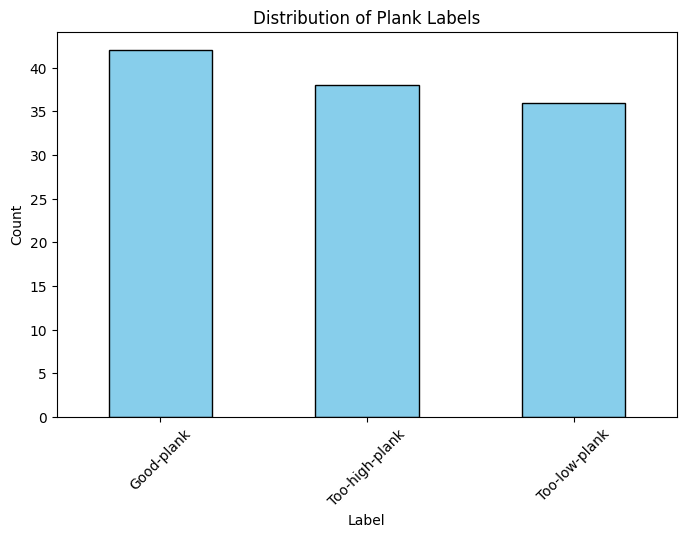

In [132]:
# 2. Distribution of Labels
label_counts = finally_plank['error-label'].value_counts()
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Plank Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [131]:
# 3. Pairplot for Coordinate Relationships (Sample Columns)
sample_coordinates = [
    'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'label'
]
sns.pairplot(finally_plank[sample_coordinates], hue='label', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Shoulder Coordinates by Label', y=1.02)
plt.show()

KeyError: "['label'] not in index"

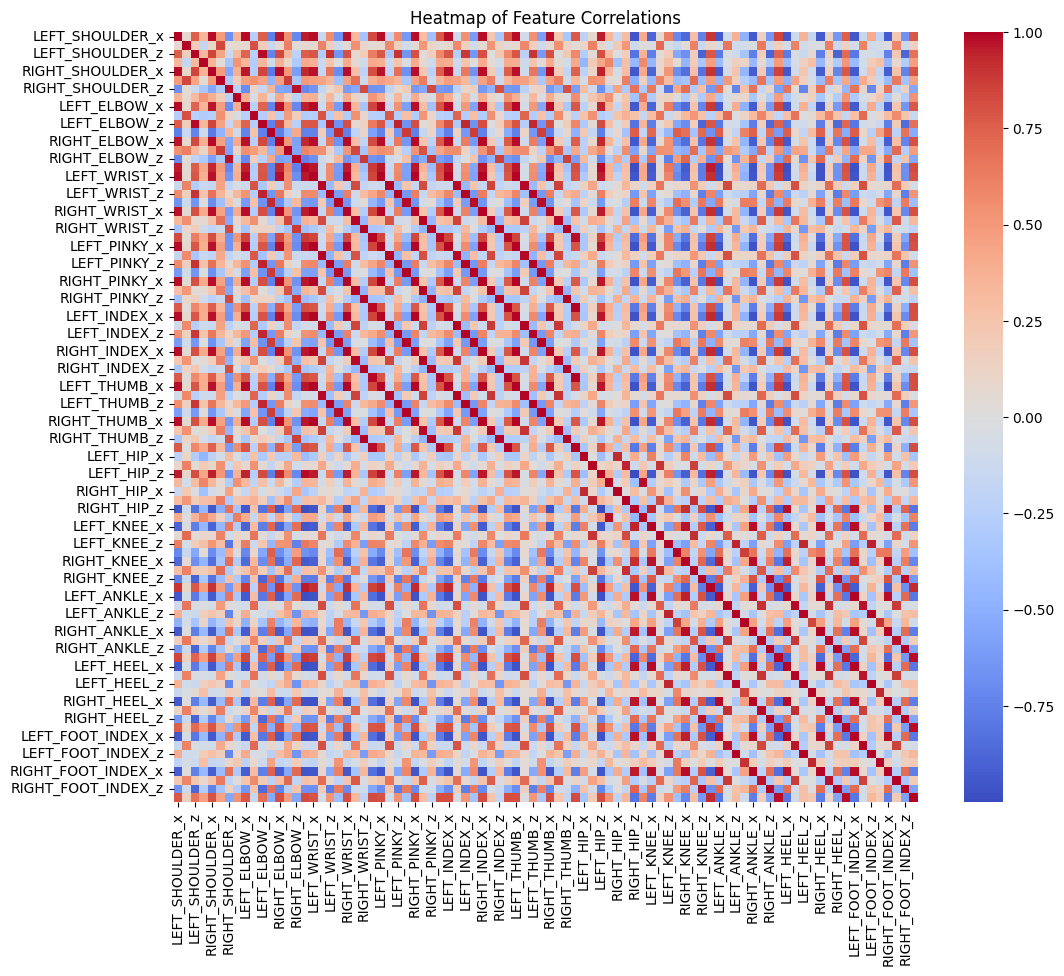

In [11]:
# 4. Heatmap of Correlations
numeric_data = finally_plank.drop(columns=['frame', 'label'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Heatmap of Feature Correlations')
plt.show()